# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
    - [Dataset Split](#Dataset-Split)
    - [PennFudanDataset Class](#PennFudanDataset-Class)
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
    - [Training and Evaluation Functions](#Training-and-Evaluation-Functions)
    - [Functions for Saving and Loading Checkpoint](#Functions-for-Saving-and-Loading-Checkpoint)
    - [Training Hyperparameters](#Training-Hyperparameters)
    - [Training for 100 Epochs at 0.001 Learning Rate](#Training-for-100-Epochs-at-0.001-Learning-Rate)
    - [Training with a Learning Rate Scheduler](#Training-with-a-Learning-Rate-Scheduler)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

##### Dataset Split

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

C:\Users\Alqia\AppData\Local\Temp\ipykernel_30660\2302059204.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))


##### PennFudanDataset Class

[Table of Contents](#Table-of-Contents)

In [4]:
def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    padded_image = cv2.resize(padded_image, (max(original_shape), max(original_shape)))
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
            return image, mask, merged_shape
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

c:\Users\Alqia\miniconda3\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


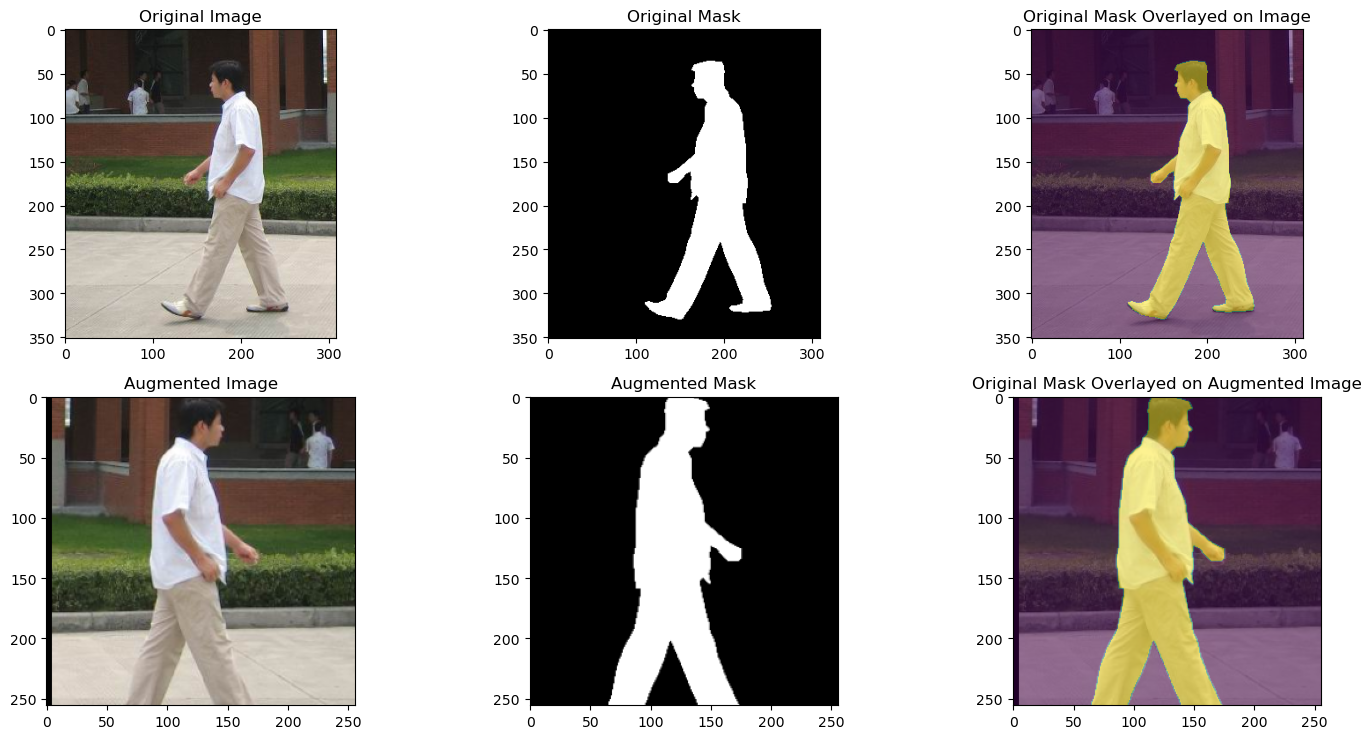

In [5]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze(), cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask.squeeze(), alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = 256

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size,scale=(0.35, 1.0), ratio=(1.0, 1.0))])
augmented_train_dataset = PennFudanDataset(
    train_image_paths, 
    train_mask_paths,
    transform=augmentation)
image, mask, _ = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze(),cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask.squeeze(), alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Augmented Image")
plt.tight_layout()
plt.show()

test_dataset = PennFudanDataset(test_image_paths, test_mask_paths, image_size=image_size)

val_dataset = PennFudanDataset(val_image_paths, val_mask_paths, image_size=image_size)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

##### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [6]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

##### Loss Function

[Table of Contents](#Table-of-Contents)

In [7]:
def dice_coefficient(output, ground_truth):
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection) / (output.sum() + ground_truth.sum())

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, output, ground_truth):
        numerical_stability = 1.
        output = output.view(-1)
        ground_truth = ground_truth.view(-1)
        intersection = (output * ground_truth).sum()
        return 1 - (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

##### Training and Evaluation Functions

[Table of Contents](#Table-of-Contents)

In [8]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask, _ in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = (model(image))
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask, _ in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = torch.round(model(image))
            loss = criterion(pred, mask)
            val_loss += loss.item()
            dice = dice_coefficient(pred, mask)
    return val_loss / len(val_loader), dice

##### Functions for Saving and Loading Checkpoint

[Table of Contents](#Table-of-Contents)

In [9]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, 
        filename)
    print(
            "Checkpoint saved:",
            "Epoch: {}".format(epoch),
            "Validation Loss: {:.4f}".format(val_loss),
            "Learning Rate: {:.3e}".format(optimizer.param_groups[0]["lr"]),
            sep="\t")
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(
        "Checkpoint loaded:",
        "Epoch: {}".format(epoch),
        "Validation Loss: {:.4f}".format(loss),
        "Learning Rate: {:.3e}".format(optimizer.param_groups[0]["lr"]),
        sep="\t")
    return model, optimizer, epoch, loss

##### Training Hyperparameters

[Table of Contents](#Table-of-Contents)

In [10]:
NUM_EPOCHS = 100
learning_rate=0.001
batchsize=8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
criterion = SoftDiceLoss()#nn.BCELoss()#
model = UNET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True)

train_losses = []
val_losses = []
dice_coeffs = []
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)

##### Training for 100 Epochs at 0.001 Learning Rate

[Table of Contents](#Table-of-Contents)

In [11]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    train_losses = train_losses[:epoch]
    val_losses = val_losses[:epoch]
else:
    epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0

while epoch < NUM_EPOCHS:
    epoch += 1
    progress_bar = tqdm(
        train_loader, 
        desc="Epoch {}".format(epoch),
        ncols=85,
        unit=" batches")
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss, dice = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    dice_coeffs.append(dice)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        count = 0
    else:
        count += 1
        if count == 5:
            print(
                "Training Progress:",
                "Train Loss: {:.4f}".format(train_loss),
                "Val Loss: {:.4f}".format(val_loss),
                sep="\t")
            count = 0

Epoch 1: 100%|█████████████████████████████████| 17/17 [00:06<00:00,  2.57 batches/s]


Checkpoint saved:	Epoch: 1	Validation Loss: 0.9978	Learning Rate: 1.000e-03


Epoch 2: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  4.22 batches/s]


Checkpoint saved:	Epoch: 2	Validation Loss: 0.8292	Learning Rate: 1.000e-03


Epoch 3: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  3.75 batches/s]


Checkpoint saved:	Epoch: 3	Validation Loss: 0.3829	Learning Rate: 1.000e-03


Epoch 5: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  3.71 batches/s]


Checkpoint saved:	Epoch: 5	Validation Loss: 0.3567	Learning Rate: 1.000e-03


Epoch 6: 100%|█████████████████████████████████| 17/17 [00:04<00:00,  3.76 batches/s]


Checkpoint saved:	Epoch: 6	Validation Loss: 0.3486	Learning Rate: 1.000e-03


Epoch 11: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Checkpoint saved:	Epoch: 11	Validation Loss: 0.3057	Learning Rate: 1.000e-03


Epoch 14: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.88 batches/s]


Checkpoint saved:	Epoch: 14	Validation Loss: 0.2872	Learning Rate: 1.000e-03


Epoch 15: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.87 batches/s]


Checkpoint saved:	Epoch: 15	Validation Loss: 0.2752	Learning Rate: 1.000e-03


Epoch 17: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Checkpoint saved:	Epoch: 17	Validation Loss: 0.2679	Learning Rate: 1.000e-03


Epoch 18: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Checkpoint saved:	Epoch: 18	Validation Loss: 0.2589	Learning Rate: 1.000e-03


Epoch 22: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Checkpoint saved:	Epoch: 22	Validation Loss: 0.2576	Learning Rate: 1.000e-03


Epoch 24: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.81 batches/s]


Checkpoint saved:	Epoch: 24	Validation Loss: 0.2311	Learning Rate: 1.000e-03


Epoch 28: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.90 batches/s]


Checkpoint saved:	Epoch: 28	Validation Loss: 0.2166	Learning Rate: 1.000e-03


Epoch 33: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Checkpoint saved:	Epoch: 33	Validation Loss: 0.2126	Learning Rate: 1.000e-03


Epoch 37: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Checkpoint saved:	Epoch: 37	Validation Loss: 0.2091	Learning Rate: 1.000e-03


Epoch 42: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Checkpoint saved:	Epoch: 42	Validation Loss: 0.2065	Learning Rate: 1.000e-03


Epoch 47: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Training Progress:	Train Loss: 0.2371	Val Loss: 0.2571


Epoch 52: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Train Loss: 0.2409	Val Loss: 0.2214


Epoch 53: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Checkpoint saved:	Epoch: 53	Validation Loss: 0.2037	Learning Rate: 1.000e-03


Epoch 58: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.95 batches/s]


Training Progress:	Train Loss: 0.2140	Val Loss: 0.2276


Epoch 63: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Training Progress:	Train Loss: 0.2330	Val Loss: 0.2211


Epoch 66: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.86 batches/s]


Checkpoint saved:	Epoch: 66	Validation Loss: 0.1936	Learning Rate: 1.000e-03


Epoch 70: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.90 batches/s]


Checkpoint saved:	Epoch: 70	Validation Loss: 0.1881	Learning Rate: 1.000e-03


Epoch 75: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Checkpoint saved:	Epoch: 75	Validation Loss: 0.1881	Learning Rate: 1.000e-03


Epoch 80: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Train Loss: 0.1931	Val Loss: 0.1915


Epoch 81: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.83 batches/s]


Checkpoint saved:	Epoch: 81	Validation Loss: 0.1830	Learning Rate: 1.000e-03


Epoch 83: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.65 batches/s]


Checkpoint saved:	Epoch: 83	Validation Loss: 0.1682	Learning Rate: 1.000e-03


Epoch 88: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Train Loss: 0.2072	Val Loss: 0.1971


Epoch 93: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Training Progress:	Train Loss: 0.1942	Val Loss: 0.1741


Epoch 98: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.99 batches/s]


Training Progress:	Train Loss: 0.1810	Val Loss: 0.1992


Epoch 100: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


##### Training with a Learning Rate Scheduler

[Table of Contents](#Table-of-Contents)

In [12]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    train_losses = train_losses[:epoch]
    val_losses = val_losses[:epoch]
else:
    epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0
while optimizer.param_groups[0]['lr'] > 1e-6 and val_loss > 0.1:
    epoch += 1
    progress_bar = tqdm(
        train_loader, 
        desc="Epoch {}".format(epoch),
        ncols=85,
        unit=" batches")
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss, dice = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    dice_coeffs.append(dice)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        count = 0
    else:
        count += 1
        if count == 5:
            print(
                "Training Progress:",
                "Epoch: {}".format(epoch),
                "Train Loss: {:.4f}".format(train_loss),
                "Val Loss: {:.4f}".format(val_loss),
                "Learning Rate = {:.1e}".format(optimizer.param_groups[0]["lr"]),
                sep="\t")
            count = 0

Checkpoint loaded:	Epoch: 83	Validation Loss: 0.1682	Learning Rate: 1.000e-03


Epoch 88: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Training Progress:	Epoch: 88	Train Loss: 0.1920	Val Loss: 0.1926	Learning Rate = 1.0e-03


Epoch 92: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.02 batches/s]


Checkpoint saved:	Epoch: 92	Validation Loss: 0.1659	Learning Rate: 1.000e-03


Epoch 97: 100%|████████████████████████████████| 17/17 [00:04<00:00,  4.00 batches/s]


Training Progress:	Epoch: 97	Train Loss: 0.1940	Val Loss: 0.2857	Learning Rate = 1.0e-03


Epoch 98: 100%|████████████████████████████████| 17/17 [00:04<00:00,  3.88 batches/s]


Checkpoint saved:	Epoch: 98	Validation Loss: 0.1646	Learning Rate: 1.000e-03


Epoch 103: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.93 batches/s]


Training Progress:	Epoch: 103	Train Loss: 0.1906	Val Loss: 0.2645	Learning Rate = 1.0e-03


Epoch 108: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.95 batches/s]


Training Progress:	Epoch: 108	Train Loss: 0.1775	Val Loss: 0.1759	Learning Rate = 1.0e-03


Epoch 113: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Training Progress:	Epoch: 113	Train Loss: 0.1881	Val Loss: 0.2017	Learning Rate = 1.0e-03


Epoch 118: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.98 batches/s]


Training Progress:	Epoch: 118	Train Loss: 0.1676	Val Loss: 0.1744	Learning Rate = 1.0e-03


Epoch 119: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.98 batches/s]


Epoch 00036: reducing learning rate of group 0 to 1.0000e-04.


Epoch 121: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Checkpoint saved:	Epoch: 121	Validation Loss: 0.1594	Learning Rate: 1.000e-04


Epoch 124: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.96 batches/s]


Checkpoint saved:	Epoch: 124	Validation Loss: 0.1582	Learning Rate: 1.000e-04


Epoch 126: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.77 batches/s]


Checkpoint saved:	Epoch: 126	Validation Loss: 0.1564	Learning Rate: 1.000e-04


Epoch 131: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.95 batches/s]


Training Progress:	Epoch: 131	Train Loss: 0.1570	Val Loss: 0.1652	Learning Rate = 1.0e-04


Epoch 136: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Epoch: 136	Train Loss: 0.1536	Val Loss: 0.1592	Learning Rate = 1.0e-04


Epoch 141: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Epoch: 141	Train Loss: 0.1510	Val Loss: 0.1592	Learning Rate = 1.0e-04


Epoch 143: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.79 batches/s]


Checkpoint saved:	Epoch: 143	Validation Loss: 0.1542	Learning Rate: 1.000e-04


Epoch 148: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.88 batches/s]


Training Progress:	Epoch: 148	Train Loss: 0.1494	Val Loss: 0.1601	Learning Rate = 1.0e-04


Epoch 153: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.97 batches/s]


Training Progress:	Epoch: 153	Train Loss: 0.1489	Val Loss: 0.1631	Learning Rate = 1.0e-04


Epoch 158: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.93 batches/s]


Training Progress:	Epoch: 158	Train Loss: 0.1519	Val Loss: 0.1681	Learning Rate = 1.0e-04


Epoch 163: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Training Progress:	Epoch: 163	Train Loss: 0.1495	Val Loss: 0.1641	Learning Rate = 1.0e-04


Epoch 164: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.99 batches/s]


Epoch 00081: reducing learning rate of group 0 to 1.0000e-05.


Epoch 168: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.95 batches/s]


Training Progress:	Epoch: 168	Train Loss: 0.1460	Val Loss: 0.1571	Learning Rate = 1.0e-05


Epoch 173: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Training Progress:	Epoch: 173	Train Loss: 0.1453	Val Loss: 0.1598	Learning Rate = 1.0e-05


Epoch 178: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.90 batches/s]


Training Progress:	Epoch: 178	Train Loss: 0.1495	Val Loss: 0.1594	Learning Rate = 1.0e-05


Epoch 183: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.95 batches/s]


Training Progress:	Epoch: 183	Train Loss: 0.1441	Val Loss: 0.1593	Learning Rate = 1.0e-05


Epoch 185: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.80 batches/s]


Epoch 00102: reducing learning rate of group 0 to 1.0000e-06.


Epoch 188: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.92 batches/s]


Training Progress:	Epoch: 188	Train Loss: 0.1469	Val Loss: 0.1587	Learning Rate = 1.0e-06


Epoch 193: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.91 batches/s]


Training Progress:	Epoch: 193	Train Loss: 0.1470	Val Loss: 0.1591	Learning Rate = 1.0e-06


Epoch 198: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.83 batches/s]


Training Progress:	Epoch: 198	Train Loss: 0.1459	Val Loss: 0.1590	Learning Rate = 1.0e-06


Epoch 203: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.94 batches/s]


Training Progress:	Epoch: 203	Train Loss: 0.1484	Val Loss: 0.1585	Learning Rate = 1.0e-06


Epoch 206: 100%|███████████████████████████████| 17/17 [00:04<00:00,  3.90 batches/s]


Epoch 00123: reducing learning rate of group 0 to 1.0000e-07.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

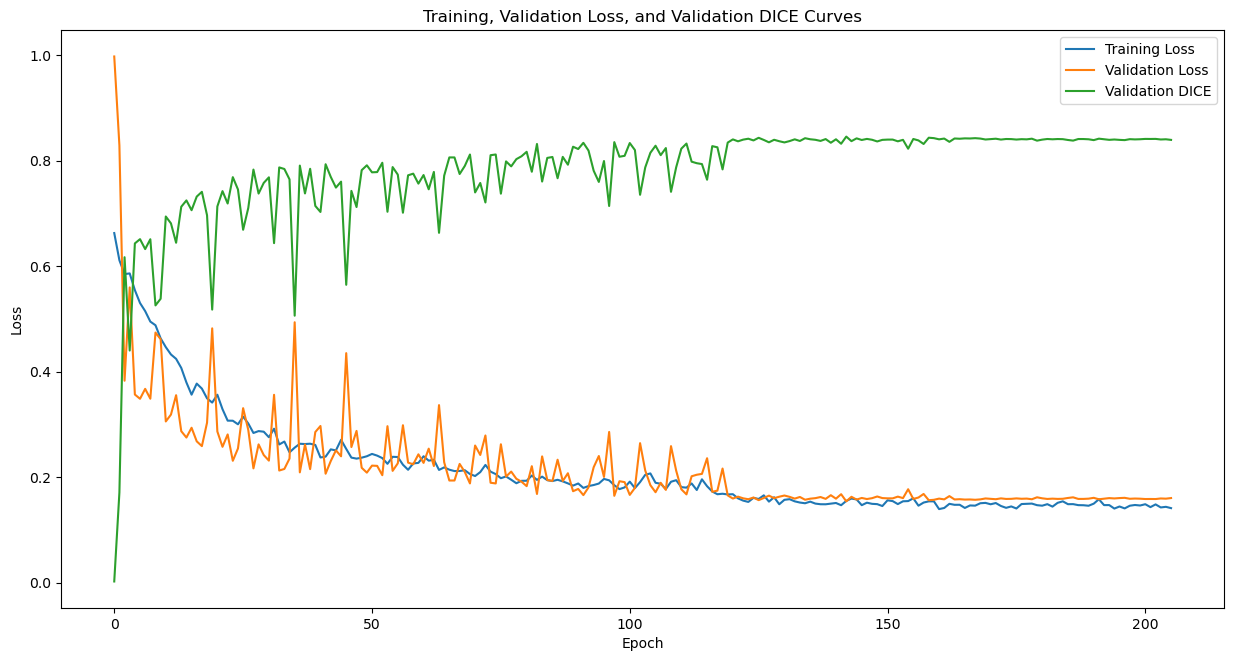

In [13]:
plt.figure(figsize=(15, 7.5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(1 - np.array(val_losses), label="Validation DICE")
plt.title("Training, Validation Loss, and Validation DICE Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

In [14]:
# Report the average dice score over your test-set.
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model.eval()
dice_coeffs = []
with torch.no_grad():
    for image, mask, shape in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        pred = torch.round(model(image))
        pred = pred.cpu()
        mask = mask.cpu()
        pred = np.squeeze(pred, axis=1)
        mask = np.squeeze(mask, axis=1)
        for i in range(pred.shape[0]):
            dice_coeffs.append(dice_coefficient(pred[i], mask[i]))
print("Average dice score: {:.4f}".format(np.mean(dice_coeffs)))

Average dice score: 0.7827


<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

Checkpoint loaded:	Epoch: 143	Validation Loss: 0.1542	Learning Rate: 1.000e-04


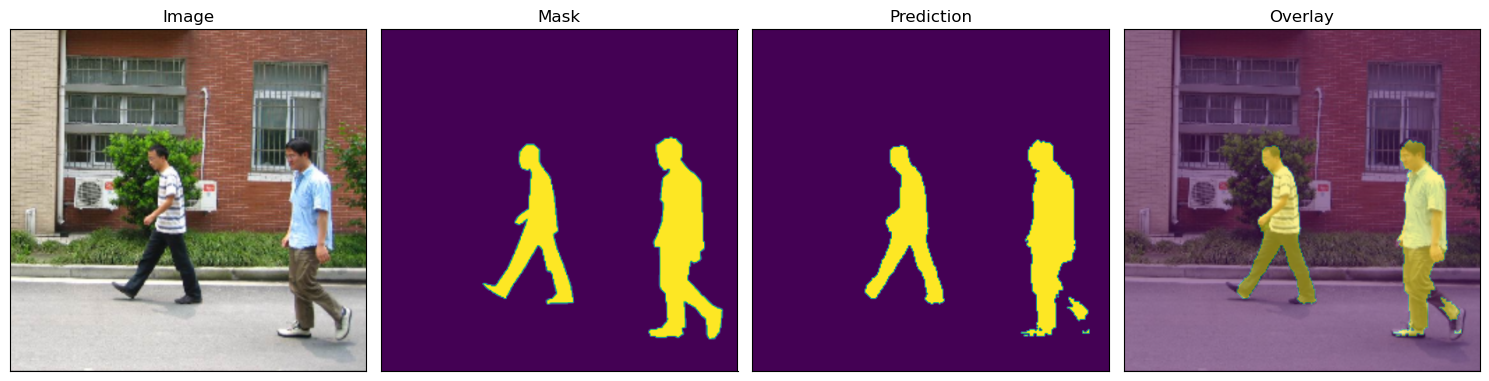

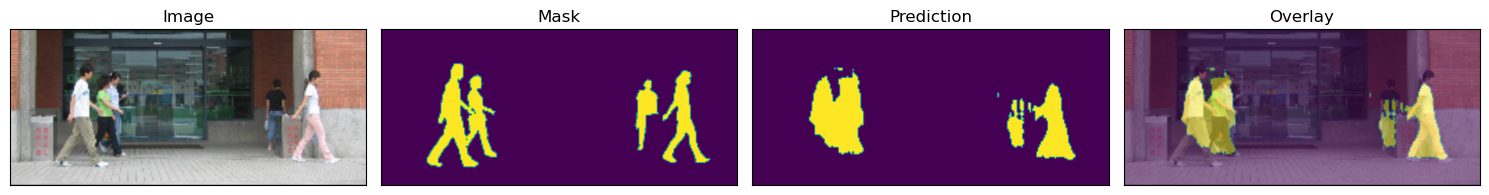

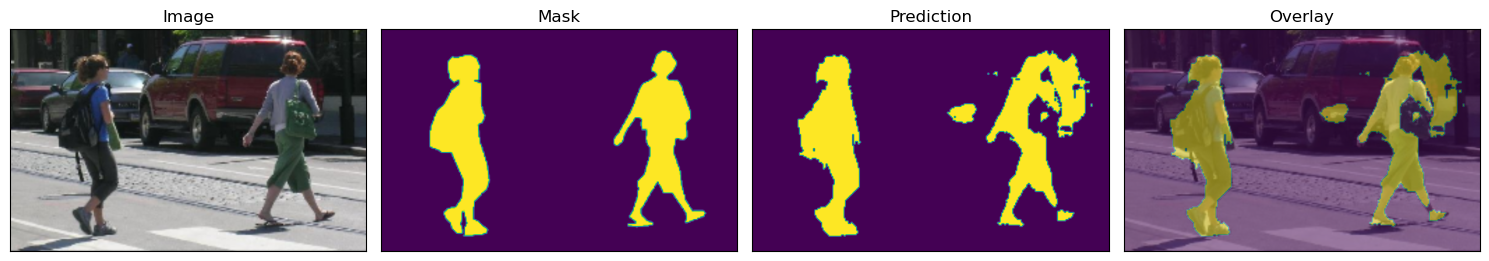

In [15]:
model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask, shape = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = torch.round(model(image))
    image = image.cpu().numpy()
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.transpose(0, 2, 3, 1)
    pred = np.squeeze(pred, axis=1)
    mask = np.squeeze(mask, axis=1)
    for i in range(3):
        fig, ax = plt.subplots(1, 4, figsize=(15, 15))
        shape_i = (int(shape[0][i]),int(shape[1][i]))
        image_i = remove_pad(image[i], shape_i)
        pred_i = remove_pad(pred[i], shape_i)
        mask_i = remove_pad(mask[i], shape_i)
        ax[0].imshow(image_i)
        ax[0].set_title("Image")
        ax[1].imshow(mask_i)
        ax[1].set_title("Mask")
        ax[2].imshow(pred_i)
        ax[2].set_title("Prediction")
        ax[3].imshow(image_i)
        ax[3].imshow(pred_i, alpha=0.5)
        ax[3].set_title("Overlay")
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()  
        plt.show()

The model is able to detect the edges of the pedestrians in the images. The model is not able to detect the pedestrians completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the pedestrians in out of distribution images that are not present in the dataset. These images use a different camera with different color composition, focus, and resolution. The model is not able to detect the pedestrians in these images because it has not seen these types of images before.

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

Checkpoint loaded:	Epoch: 143	Validation Loss: 0.1542	Learning Rate: 1.000e-04


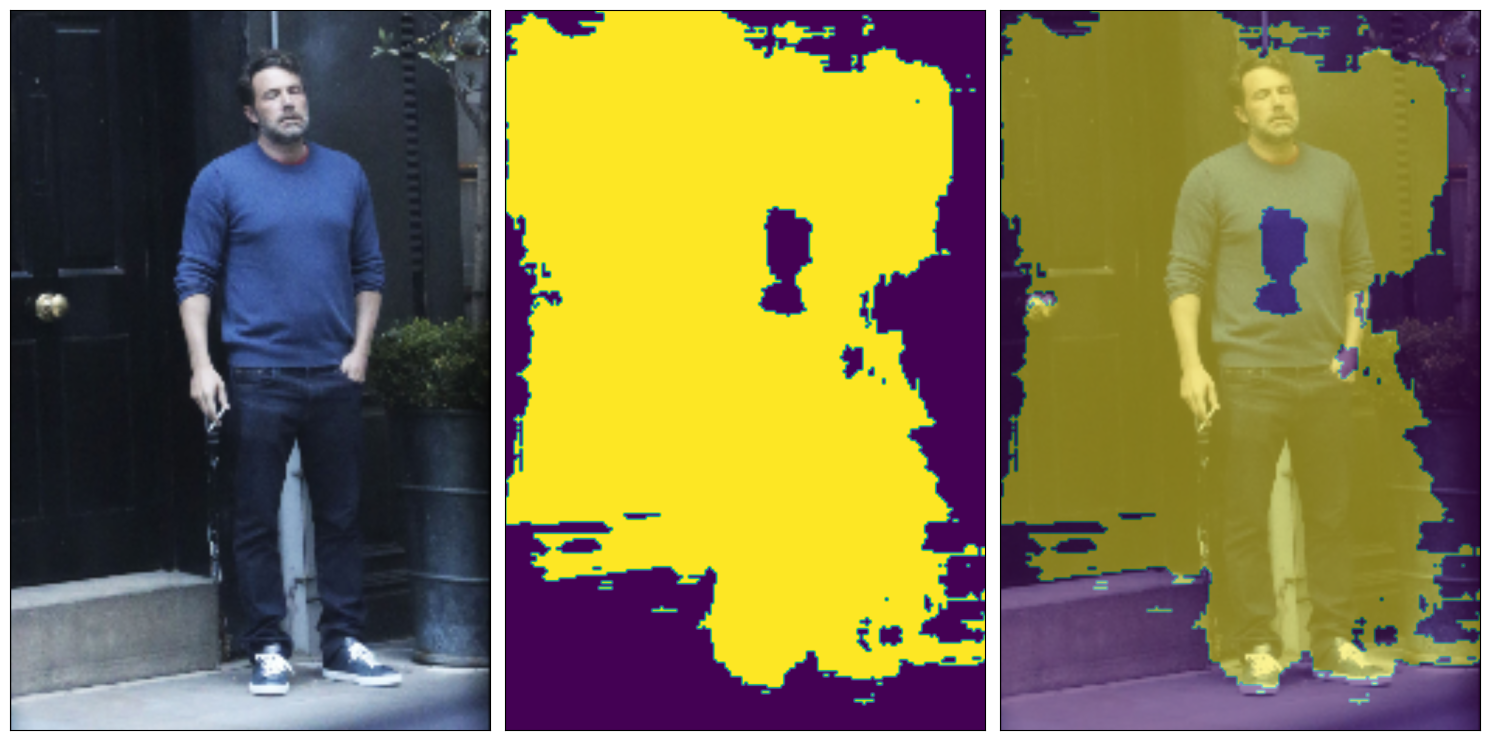

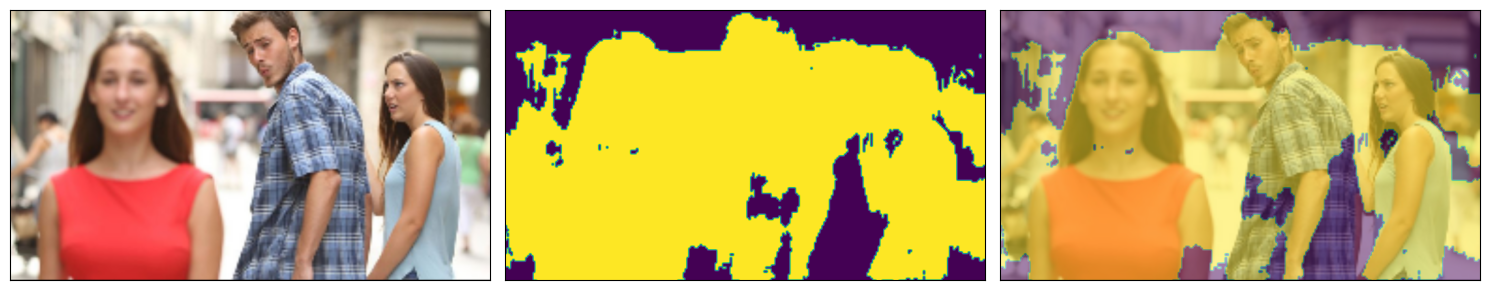

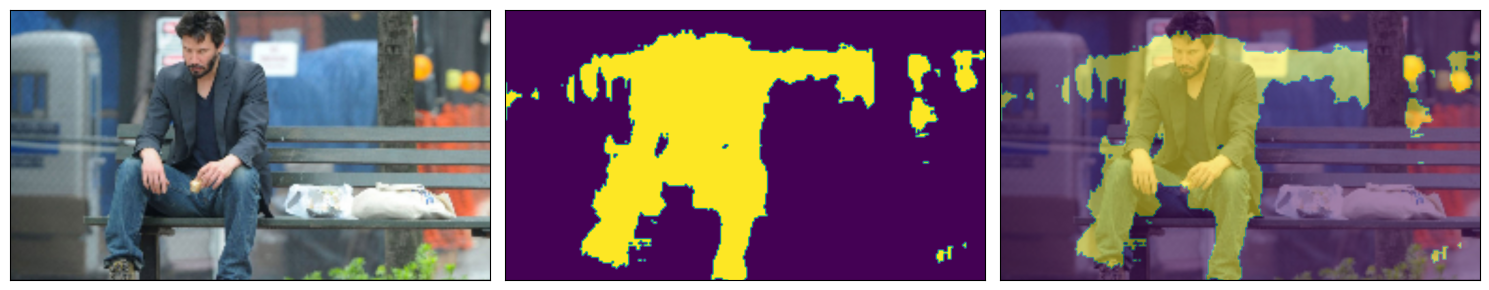

In [16]:
model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
   for image in os.listdir("./out_of_distribution_images"):
      image = cv2.imread(os.path.join("./out_of_distribution_images", image))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image, shape = square_pad(image)
      image = cv2.resize(image, (image_size, image_size))
      image = image.transpose(2, 0, 1)
      image = image / 255
      image = torch.from_numpy(image).float()
      image = image.to(device)
      pred = model(image[None, ...])
      pred = torch.round(pred)
      pred = pred.cpu().numpy()
      pred = np.squeeze(pred)
      pred = remove_pad(pred, shape)
      image = image.cpu().numpy()
      image = image.transpose(1, 2, 0)
      image = remove_pad(image, shape)
      plt.figure(figsize=(15, 15))
      plt.subplot(1, 3, 1)
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])
      plt.subplot(1, 3, 2)
      plt.imshow(pred)
      plt.xticks([])
      plt.yticks([])
      plt.subplot(1, 3, 3)
      plt.imshow(image)
      plt.imshow(pred, alpha=0.5)
      plt.xticks([])
      plt.yticks([])
      plt.tight_layout()
      plt.show()

In [17]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README.md

[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 4775597 bytes to aaz7118-CA04.html
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README_files\
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 47847 bytes to README.md
